In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [3]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]

In [4]:
import os
from langchain.chat_models import init_chat_model
from langchain_deepseek import ChatDeepSeek

os.environ["OPENAI_API_KEY"] = "sk-..."

llm = ChatDeepSeek(model ="deepseek-reasoner")

In [5]:
# 时间工具
from langchain.tools import tool
from datetime import datetime

@tool("get_now_time", description="获取当前时间")
def get_now_time() ->str :
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

In [6]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool, get_now_time]

In [7]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [8]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [9]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

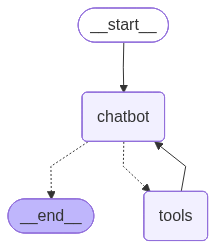

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

def stream_graph_2(user_input: str):
    for chunk, meta in graph.stream({"messages": [{"role": "user", "content": user_input}]}, stream_mode="messages"):
        print(chunk)


user_input = "帮我查询现在的时间"
stream_graph_2(user_input)


content='' additional_kwargs={} response_metadata={} id='run--2737ac09-8638-4695-b12f-c6aec277f25b'
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_00_OXU1E8CveyesloDK2yUFWkK2', 'function': {'arguments': '', 'name': 'get_now_time'}, 'type': 'function'}]} response_metadata={} id='run--2737ac09-8638-4695-b12f-c6aec277f25b' tool_calls=[{'name': 'get_now_time', 'args': {}, 'id': 'call_00_OXU1E8CveyesloDK2yUFWkK2', 'type': 'tool_call'}] tool_call_chunks=[{'name': 'get_now_time', 'args': '', 'id': 'call_00_OXU1E8CveyesloDK2yUFWkK2', 'index': 0, 'type': 'tool_call_chunk'}]
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': None, 'function': {'arguments': '{}', 'name': None}, 'type': None}]} response_metadata={} id='run--2737ac09-8638-4695-b12f-c6aec277f25b' tool_calls=[{'name': '', 'args': {}, 'id': None, 'type': 'tool_call'}] tool_call_chunks=[{'name': None, 'args': '{}', 'id': None, 'index': 0, 'type': 'tool_call_chunk'}]
content='' additional_kwargs={} re